Cross Validation 1

size = 20247

test size 4k+

epoch-3

apply sigmoid (prediction probabilities are logits)

groups-9

target_list = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']

threshold-tuning = yes

df_2k = df[(df['Rating'] >= 4.5) & (df['Maximum_Installs'] >= 20000)]

accuracy score : F1 score (micro) and ROC_AUC score

## 1. Setup

In [1]:
!pip install sentencepiece

In [2]:
!pip install transformers

--- reconnect --

In [3]:
import os
import math

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla T4


## 2. Load Dataset

In [5]:
## uploading csv files on drive (to avoid uploading on colab in every session)

from google.colab import drive
drive.mount("/content/drive/")

## drive path
train_path = "/content/drive/MyDrive/MetadataCSV/data_20247/CV_df_train_1.csv"
val_path = "/content/drive/MyDrive/MetadataCSV/data_20247/CV_df_val_1.csv"
test_path = "/content/drive/MyDrive/MetadataCSV/test_dataset.csv"

Mounted at /content/drive/


In [6]:
df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path) 
df_test = pd.read_csv(test_path)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(16198, 23)
(4049, 23)
(4624, 23)


In [7]:
df_train.head(2)

,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,Camera,...,Contacts,SMS,Storage,Phone,Get_Accounts,Call_Log,desc_length,Clean_Description,clean_desc_length,token_length
0,Fortune Teller Khmer,com.khemarasoft.fortuneteller,Lifestyle,4.5,50284,False,Want to find out your future? This app is a mu...,http://khemarasoft.com/app-policy,0,0,...,0,0,0,0,0,0,370,want to find out your future? this app is a mu...,365,76
1,Mrsool | مرسول,com.mrsool,Shopping,4.5,6450386,False,Mrsool is one of the largest delivery platform...,https://s.mrsool.co/privacy_policy.html,0,1,...,0,0,1,1,1,0,1356,mrsool is one of the largest delivery platform...,1310,267


In [8]:
target_list = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']

In [9]:
# getting number of nonzeros in each column
df_train[target_list].astype(bool).sum(axis=0)

Camera        2491
Location      2465
Microphone    1491
Contacts      1669
Storage       8223
Phone         2411
SMS             60
Call_Log        35
Calendar       279
dtype: int64

In [10]:
df_val[target_list].astype(bool).sum(axis=0)

Camera         607
Location       615
Microphone     359
Contacts       381
Storage       2030
Phone          588
SMS             11
Call_Log         8
Calendar        73
dtype: int64

In [11]:
df_test[target_list].astype(bool).sum(axis=0)

Camera         745
Location       716
Microphone     436
Contacts       500
Storage       2402
Phone          652
SMS             11
Call_Log         6
Calendar        90
dtype: int64

## 3. XLNet Tokenizer - Preprocess Data

### 3.1. Tokenize

In [12]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

In [13]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [14]:
train_text_list = df_train['Clean_Description'].values
val_text_list = df_val['Clean_Description'].values
test_text_list = df_test['Clean_Description'].values

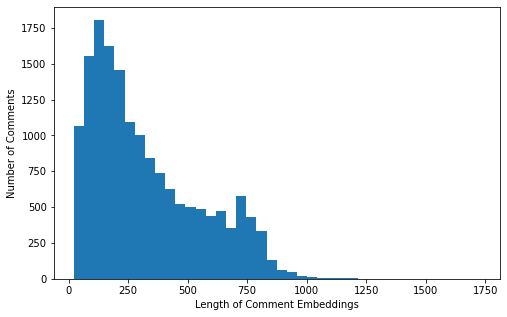

In [15]:
plot_sentence_embeddings_length(train_text_list, tokenizer)

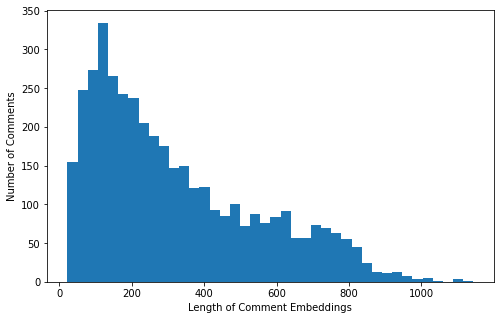

In [16]:
plot_sentence_embeddings_length(val_text_list, tokenizer)

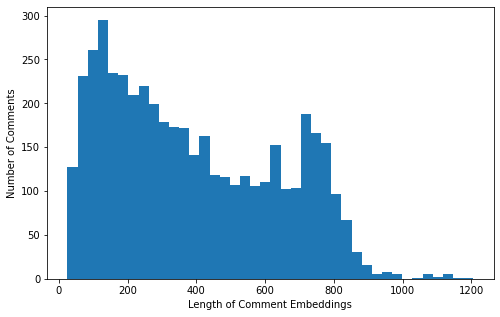

In [17]:
plot_sentence_embeddings_length(test_text_list, tokenizer)

In [18]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [19]:
# create input id tokens
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=250)
train_input_ids

array([[  210,    22,   278, ...,     0,     0,     0],
       [   17,    98,  1114, ...,     9,     4,     3],
       [   17,  7969,  2731, ...,     0,     0,     0],
       ...,
       [   52,   325, 14969, ...,     0,     0,     0],
       [   52,  1479,    17, ...,    53,     4,     3],
       [   36,  1849,   211, ...,   142,     4,     3]])

In [20]:
# create input id tokens
val_input_ids = tokenize_inputs(val_text_list, tokenizer, num_embeddings=250)
val_input_ids

array([[ 3523,    17,  1575, ..., 14682,     4,     3],
       [   52,  5523,   154, ...,  8045,     4,     3],
       [ 3124,    22,    18, ...,     0,     0,     0],
       ...,
       [   17,     9,    17, ...,     0,     0,     0],
       [11893, 10883,  3941, ...,    22,     4,     3],
       [  435,  1272,    20, ...,     0,     0,     0]])

In [21]:
# create input id tokens
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=250)
test_input_ids

array([[  108,    44,    41, ...,     0,     0,     0],
       [ 2039,    40,  8425, ...,     0,     0,     0],
       [   17, 12293,  2686, ...,   177,     4,     3],
       ...,
       [26941,   669,    17, ...,   751,     4,     3],
       [ 1184,  2387,  1603, ...,   181,     4,     3],
       [  113,   108,  4626, ...,  1304,     4,     3]])

### 3.2. Attention Masks

In [22]:
# create attention masks
train_attention_masks = create_attn_masks(train_input_ids)
#train_attention_masks

In [23]:
# create attention masks
val_attention_masks = create_attn_masks(val_input_ids)
#val_attention_masks

In [24]:
# create attention masks
test_attention_masks = create_attn_masks(test_input_ids)
#test_attention_masks

In [25]:
# add input ids and attention masks to the dataframe
df_train["features"] = train_input_ids.tolist()
df_train["masks"] = train_attention_masks

df_val["features"] = val_input_ids.tolist()
df_val["masks"] = val_attention_masks

df_test["features"] = test_input_ids.tolist()
df_test["masks"] = test_attention_masks

In [26]:
df_train.head(2)

,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,Camera,...,Storage,Phone,Get_Accounts,Call_Log,desc_length,Clean_Description,clean_desc_length,token_length,features,masks
0,Fortune Teller Khmer,com.khemarasoft.fortuneteller,Lifestyle,4.5,50284,False,Want to find out your future? This app is a mu...,http://khemarasoft.com/app-policy,0,0,...,0,0,0,0,370,want to find out your future? this app is a mu...,365,76,"[210, 22, 278, 78, 73, 623, 82, 52, 5523, 27, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,Mrsool | مرسول,com.mrsool,Shopping,4.5,6450386,False,Mrsool is one of the largest delivery platform...,https://s.mrsool.co/privacy_policy.html,0,1,...,1,1,1,0,1356,mrsool is one of the largest delivery platform...,1310,267,"[17, 98, 1114, 155, 1529, 27, 65, 20, 18, 942,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [27]:
df_val.head(2)

,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,Camera,...,Storage,Phone,Get_Accounts,Call_Log,desc_length,Clean_Description,clean_desc_length,token_length,features,masks
0,Classic Os12 Keyboard Theme,com.ikeyboard.theme.classic.os12,Personalization,4.6,35419,False,✨Classic Os12 Keyboard Theme with new cool fon...,http://www.kikatech.com/privacy_en_kika_keyboa...,0,0,...,1,0,0,0,2948,classic os keyboard theme with new cool fonts ...,2812,577,"[3523, 17, 1575, 8097, 3941, 33, 109, 2299, 11...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,Hidden Camera Detector :Electronic Device Finder,com.ud.hidden.spy.camera.detectorpro.free2020,Tools,4.7,21358,False,This app work only Magnetometer sensor if your...,https://sites.google.com/view/unitedtechworld/...,0,1,...,0,0,0,0,2424,this app work only magnetometer sensor if your...,2346,454,"[52, 5523, 154, 114, 13169, 17934, 14886, 108,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [28]:
df_test.head(2)

,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,Camera,...,Storage,Phone,Get_Accounts,Call_Log,desc_length,Clean_Description,clean_desc_length,token_length,features,masks
0,Urdu Poetry Offline,com.wikitech.UrduShayari,Entertainment,4.9,567189,False,If you are a poetry lover and did not find the...,https://sites.google.com/view/offlineurdupoetr...,0,0,...,1,0,0,0,901,if you are a poetry lover and did not find the...,876,191,"[108, 44, 41, 24, 7163, 11139, 21, 190, 50, 27...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,"53,000+ Famous Quotes Free",com.webworks.freequotes,Entertainment,4.8,293524,False,*Note from Developer: Force close on Froyo 2.2...,http://www.kappboom.com/tos.html,0,0,...,1,0,0,0,302,note from developer force close on froyo . fir...,284,70,"[2039, 40, 8425, 779, 474, 31, 17, 12803, 4333...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


### 3.3. Train, Valid Split

In [29]:
X_train = df_train["features"].values.tolist()
X_valid = df_val["features"].values.tolist()

train_masks = df_train["masks"].values.tolist()
valid_masks = df_val["masks"].values.tolist()

label_cols = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']
Y_train = df_train[label_cols].values.tolist()
Y_valid = df_val[label_cols].values.tolist()

### 3.4. Create Dataloaders

In [30]:
# Convert all of our input ids and attention masks into 
# torch tensors, the required datatype for our model

X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [31]:
# Select a batch size for training
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

In [32]:
# Function for class weights

import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)

    print(class_series)
    print(class_labels)

    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])
    #print(n_samples)
    #print(n_classes)

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    #return dict(zip(class_labels, class_weights))
    return class_weights

In [33]:
class_series = np.array(Y_train)
class_wt = generate_class_weights(class_series, multi_class=False, one_hot_encoded=True)
print(class_wt)
class_wt = torch.tensor(class_wt)
print(class_wt)

[0.7225121548686382, 0.7301329727293216, 1.207094418362024, 1.0783569669129884, 0.21887118786060777, 0.7464860131803309, 29.996296296296297, 51.422222222222224, 6.450816407805655]
tensor([ 0.7225,  0.7301,  1.2071,  1.0784,  0.2189,  0.7465, 29.9963, 51.4222,
         6.4508])


## 4. XLNet Fine Tuning

### 4.1. Train our model

In [34]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch

      ##
      #mycode-start
      class_wt = generate_class_weights(class_series, multi_class=False, one_hot_encoded=True)
      class_wt = torch.tensor(class_wt)
      class_wt = class_wt.to(device)
      #mycode-end

      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
     
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

### 4.2. XLNetForMultiLabelSequenceClassification

In [35]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      class_wt = generate_class_weights(class_series, multi_class=False, one_hot_encoded=True)
      class_wt = torch.tensor(class_wt)
      class_wt = class_wt.to('cuda')
      loss_fct = BCEWithLogitsLoss(pos_weight=class_wt)
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
#model.cuda()

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 4.3. Optimizer & Learning Rate Scheduler

In [36]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


### 4.4. Training Loop

In [37]:
num_epochs=3

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "drive/My Drive/Models/xlnet_mod5.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.017361785084513297
Valid loss: 0.014084465338009673


Epoch:  33%|███▎      | 1/3 [25:23<50:46, 1523.17s/it]

Saving model at epoch 0 with validation loss of 0.014084465338009673


Train loss: 0.013346156961861724
Valid loss: 0.013325401632196669


Epoch:  67%|██████▋   | 2/3 [50:48<25:24, 1524.21s/it]

Saving model at epoch 1 with validation loss of 0.013325401632196669


Train loss: 0.011326179075546877


Epoch: 100%|██████████| 3/3 [1:16:12<00:00, 1524.03s/it]

Valid loss: 0.013910715388873384




Text(0.5, 1.0, 'Loss vs Number of Epochs')

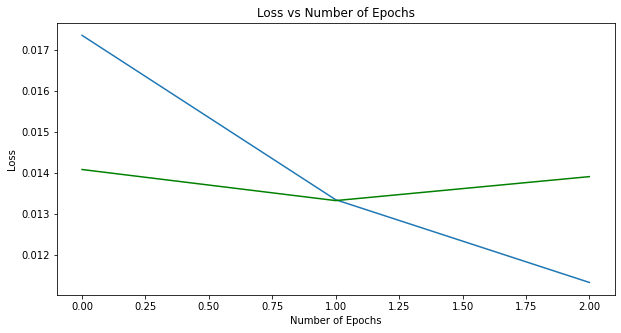

In [38]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

## 5. Performance On Test Set

In [39]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [40]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, df_test, num_labels, device="cuda", batch_size=32)
pred_probs

array([[8.72145686e-03, 6.69509694e-02, 2.39378903e-02, ...,
        3.01579421e-04, 3.83480728e-05, 2.57689535e-04],
       [2.62965802e-02, 2.54319869e-02, 2.50878893e-02, ...,
        8.99600622e-04, 1.05217245e-04, 6.82101061e-04],
       [4.15554941e-01, 4.63566154e-01, 6.46236598e-01, ...,
        6.20228387e-02, 3.11606415e-02, 3.77693176e-01],
       ...,
       [6.22408390e-01, 2.43805781e-01, 4.21196729e-01, ...,
        2.45722421e-02, 1.34634553e-02, 2.52219260e-01],
       [4.38174559e-03, 9.43806648e-01, 9.99482274e-01, ...,
        2.68494099e-04, 7.67326448e-04, 1.24472298e-03],
       [1.23278471e-02, 1.79982334e-02, 1.36153270e-02, ...,
        1.93453173e-03, 1.08979599e-04, 6.50061760e-04]])

In [41]:
label_cols = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']

df_test['P_Camera'] = pred_probs[:,0]
df_test['P_Location'] = pred_probs[:,1]
df_test['P_Microphone'] = pred_probs[:,2]
df_test['P_Contacts'] = pred_probs[:,3]
df_test['P_Storage'] = pred_probs[:,4]
df_test['P_Phone'] = pred_probs[:,5]
df_test['P_SMS'] = pred_probs[:,6]
df_test['P_Call_Log'] = pred_probs[:,7]
df_test['P_Calendar'] = pred_probs[:,8]

In [42]:
df_test.head(2)

,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,Camera,...,masks,P_Camera,P_Location,P_Microphone,P_Contacts,P_Storage,P_Phone,P_SMS,P_Call_Log,P_Calendar
0,Urdu Poetry Offline,com.wikitech.UrduShayari,Entertainment,4.9,567189,False,If you are a poetry lover and did not find the...,https://sites.google.com/view/offlineurdupoetr...,0,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.008721,0.066951,0.023938,0.028399,0.445655,0.071279,0.000302,0.000038,0.000258
1,"53,000+ Famous Quotes Free",com.webworks.freequotes,Entertainment,4.8,293524,False,*Note from Developer: Force close on Froyo 2.2...,http://www.kappboom.com/tos.html,0,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.026297,0.025432,0.025088,0.023188,0.189954,0.023116,0.000900,0.000105,0.000682


In [43]:
test_to_csv = df_test.reset_index()
test_to_csv.head(2)

,index,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,...,masks,P_Camera,P_Location,P_Microphone,P_Contacts,P_Storage,P_Phone,P_SMS,P_Call_Log,P_Calendar
0,0,Urdu Poetry Offline,com.wikitech.UrduShayari,Entertainment,4.9,567189,False,If you are a poetry lover and did not find the...,https://sites.google.com/view/offlineurdupoetr...,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.008721,0.066951,0.023938,0.028399,0.445655,0.071279,0.000302,0.000038,0.000258
1,1,"53,000+ Famous Quotes Free",com.webworks.freequotes,Entertainment,4.8,293524,False,*Note from Developer: Force close on Froyo 2.2...,http://www.kappboom.com/tos.html,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.026297,0.025432,0.025088,0.023188,0.189954,0.023116,0.000900,0.000105,0.000682


In [44]:
true_l = df_test[['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']]
pred_l = df_test[['P_Camera', 'P_Location', 'P_Microphone', 'P_Contacts', 'P_Storage', 'P_Phone', 'P_SMS', 'P_Call_Log', 'P_Calendar']]


In [45]:
true_labels = true_l.to_numpy()
predictions = pred_l.to_numpy()

In [46]:
np.save("true_labels.npy", true_labels)
np.save("predictions.npy", predictions)

In [47]:
predictions

array([[8.72145686e-03, 6.69509694e-02, 2.39378903e-02, ...,
        3.01579421e-04, 3.83480728e-05, 2.57689535e-04],
       [2.62965802e-02, 2.54319869e-02, 2.50878893e-02, ...,
        8.99600622e-04, 1.05217245e-04, 6.82101061e-04],
       [4.15554941e-01, 4.63566154e-01, 6.46236598e-01, ...,
        6.20228387e-02, 3.11606415e-02, 3.77693176e-01],
       ...,
       [6.22408390e-01, 2.43805781e-01, 4.21196729e-01, ...,
        2.45722421e-02, 1.34634553e-02, 2.52219260e-01],
       [4.38174559e-03, 9.43806648e-01, 9.99482274e-01, ...,
        2.68494099e-04, 7.67326448e-04, 1.24472298e-03],
       [1.23278471e-02, 1.79982334e-02, 1.36153270e-02, ...,
        1.93453173e-03, 1.08979599e-04, 6.50061760e-04]])

In [48]:
true_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## 6. Threshold Calculation

In [49]:
# Import module for data manipulation
import pandas as pd
# Import module for linear algebra
import numpy as np
# Import module for data simulation
from sklearn.datasets import make_classification     # Create a synthetic dataframe
from sklearn.linear_model import LogisticRegression  # Classification model
from sklearn.model_selection import train_test_split # Split the dataframe
from sklearn.metrics import roc_curve                # Calculate the ROC curve
from sklearn.metrics import precision_recall_curve   # Calculate the Precision-Recall curve
from sklearn.metrics import f1_score                 # Calculate the F-score
# Import module for data visualization
from plotnine import *
import plotnine

In [50]:
thresh_f = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
thresh_roc = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [51]:
n = 9
for i in range(0, n):
  print('permission ',i)

  predictions = np.load("predictions.npy")
  true_labels = np.load("true_labels.npy")

  # Array for finding the optimal threshold
  thresholds = np.arange(0.0, 1.0, 0.0001)
  fscore = np.zeros(shape=(len(thresholds)))
  print('Length of sequence: {}'.format(len(thresholds)))

  labels = true_labels[:, i]
  pred = predictions[:, i]

  # Fit the model
  for index, elem in enumerate(thresholds):
    # Corrected probabilities
    y_pred_prob = (pred > elem).astype('int')
    # Calculate the f-score
    fscore[index] = f1_score(labels, y_pred_prob)

  # Find the optimal threshold
  index = np.argmax(fscore)
  thresholdOpt = round(thresholds[index], ndigits = 4)
  fscoreOpt = round(fscore[index], ndigits = 4)
  thresh_f[i] = thresholdOpt
  print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

print("-------------------------------------")
print("optimal threshold tuning for f-score")
print(thresh_f)

permission  0
Length of sequence: 10000
Best Threshold: 0.3355 with F-Score: 0.6449
permission  1
Length of sequence: 10000
Best Threshold: 0.2875 with F-Score: 0.5755
permission  2
Length of sequence: 10000
Best Threshold: 0.422 with F-Score: 0.5316
permission  3
Length of sequence: 10000
Best Threshold: 0.3954 with F-Score: 0.5208
permission  4
Length of sequence: 10000
Best Threshold: 0.2301 with F-Score: 0.7821
permission  5
Length of sequence: 10000
Best Threshold: 0.2712 with F-Score: 0.5022
permission  6
Length of sequence: 10000
Best Threshold: 0.6556 with F-Score: 0.0811
permission  7
Length of sequence: 10000
Best Threshold: 0.9999 with F-Score: 0.4286
permission  8
Length of sequence: 10000
Best Threshold: 0.7027 with F-Score: 0.3959
-------------------------------------
optimal threshold tuning for f-score
[0.3355, 0.2875, 0.422, 0.3954, 0.2301, 0.2712, 0.6556, 0.9999, 0.7027]


In [52]:
##for roc curve with g-mean

n = 9
for i in range(0, n):
  print('permission ',i)

  predictions = np.load("predictions.npy")
  true_labels = np.load("true_labels.npy")

  labels = true_labels[:, i]
  pred = predictions[:, i]

  # Create the ROC curve
  fpr, tpr, thresholds = roc_curve(labels, pred)

  df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})

  # Calculate the G-mean
  gmean = np.sqrt(tpr * (1 - fpr))

  # Find the optimal threshold
  index = np.argmax(gmean)
  thresholdOpt = round(thresholds[index], ndigits = 4)
  gmeanOpt = round(gmean[index], ndigits = 4)
  fprOpt = round(fpr[index], ndigits = 4)
  tprOpt = round(tpr[index], ndigits = 4)

  thresh_roc[i] = thresholdOpt
  print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
  print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

print("-------------------------------------")
print("ROC curve with G-mean threshold tuning")
print(thresh_roc)

permission  0
Best Threshold: 0.1196 with G-Mean: 0.8289
FPR: 0.1913, TPR: 0.8497
permission  1
Best Threshold: 0.1512 with G-Mean: 0.7721
FPR: 0.1663, TPR: 0.7151
permission  2
Best Threshold: 0.1449 with G-Mean: 0.8197
FPR: 0.2082, TPR: 0.8486
permission  3
Best Threshold: 0.1825 with G-Mean: 0.7985
FPR: 0.1763, TPR: 0.774
permission  4
Best Threshold: 0.3057 with G-Mean: 0.766
FPR: 0.2291, TPR: 0.761
permission  5
Best Threshold: 0.0944 with G-Mean: 0.7493
FPR: 0.2893, TPR: 0.7899
permission  6
Best Threshold: 0.1491 with G-Mean: 0.905
FPR: 0.0991, TPR: 0.9091
permission  7
Best Threshold: 0.056 with G-Mean: 0.8904
FPR: 0.0487, TPR: 0.8333
permission  8
Best Threshold: 0.248 with G-Mean: 0.8386
FPR: 0.133, TPR: 0.8111
-------------------------------------
ROC curve with G-mean threshold tuning
[0.1196, 0.1512, 0.1449, 0.1825, 0.3057, 0.0944, 0.1491, 0.056, 0.248]


## 7. Performance Score

In [ ]:
#Fscore micro for different thresholds-

In [53]:
#predictions = np.load("predictions.npy")
predictions = np.load("predictions.npy")
true_labels = np.load("true_labels.npy")

In [54]:
# Function to calculate the accuracy of our predictions vs labels

import numpy as np
from sklearn.metrics import f1_score

def f_at_1(preds, labels):
    #print('my_print_2')
    acc = [0, 0 ,0 ,0 ,0 ,0, 0, 0, 0]
    preds_th = preds
    
    preds_th[:, 0] = np.array(preds[:, 0]) >= thresh_f[0]
    preds_th[:, 1] = np.array(preds[:, 1]) >= thresh_f[1]
    preds_th[:, 2] = np.array(preds[:, 2]) >= thresh_f[2]
    preds_th[:, 3] = np.array(preds[:, 3]) >= thresh_f[3]
    preds_th[:, 4] = np.array(preds[:, 4]) >= thresh_f[4]
    preds_th[:, 5] = np.array(preds[:, 5]) >= thresh_f[5]
    preds_th[:, 6] = np.array(preds[:, 6]) >= thresh_f[6]
    preds_th[:, 7] = np.array(preds[:, 7]) >= thresh_f[7]
    preds_th[:, 8] = np.array(preds[:, 8]) >= thresh_f[8]

   
    acc[0] = f1_score(labels[:, 0], preds_th[:, 0])
    acc[1] = f1_score(labels[:, 1], preds_th[:, 1])
    acc[2] = f1_score(labels[:, 2], preds_th[:, 2])
    acc[3] = f1_score(labels[:, 3], preds_th[:, 3])
    acc[4] = f1_score(labels[:, 4], preds_th[:, 4])
    acc[5] = f1_score(labels[:, 5], preds_th[:, 5])
    acc[6] = f1_score(labels[:, 6], preds_th[:, 6])
    acc[7] = f1_score(labels[:, 7], preds_th[:, 7])
    acc[8] = f1_score(labels[:, 8], preds_th[:, 8])

   #f1_score_micro = metrics.f1_score(targets, outputs, average='micro')

    #print(acc)
    return acc

In [55]:
eval_accuracy = f_at_1(predictions, true_labels)

np.save("F1_CV1_N20k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.
print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")
avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average F1 score: {0:.4f}".format(avg_score))

  Camera    : 0.6449
  Location  : 0.5755
  Microphone: 0.5316
  Contacts  : 0.5208
  Storage   : 0.7821
  Phone     : 0.5022
  SMS       : 0.0811
  Call_Log  : 0.4286
  Calendar  : 0.3959

  Average F1 score: 0.4958


In [ ]:
#Fscore micro for different thresholds-

In [56]:
#predictions = np.load("predictions.npy")
predictions = np.load("predictions.npy")
true_labels = np.load("true_labels.npy")

In [57]:
# Function to calculate the accuracy of our predictions vs labels

import numpy as np
from sklearn.metrics import f1_score

def f1micro_accuracy(preds, labels):
    #print('my_print_2')
    acc = [0, 0 ,0 ,0 ,0 ,0, 0, 0, 0]
    preds_th = preds
    
    preds_th[:, 0] = np.array(preds[:, 0]) >= thresh_f[0]
    preds_th[:, 1] = np.array(preds[:, 1]) >= thresh_f[1]
    preds_th[:, 2] = np.array(preds[:, 2]) >= thresh_f[2]
    preds_th[:, 3] = np.array(preds[:, 3]) >= thresh_f[3]
    preds_th[:, 4] = np.array(preds[:, 4]) >= thresh_f[4]
    preds_th[:, 5] = np.array(preds[:, 5]) >= thresh_f[5]
    preds_th[:, 6] = np.array(preds[:, 6]) >= thresh_f[6]
    preds_th[:, 7] = np.array(preds[:, 7]) >= thresh_f[7]
    preds_th[:, 8] = np.array(preds[:, 8]) >= thresh_f[8]

    acc[0] = f1_score(labels[:, 0], preds_th[:, 0], average='micro')
    acc[1] = f1_score(labels[:, 1], preds_th[:, 1], average='micro')
    acc[2] = f1_score(labels[:, 2], preds_th[:, 2], average='micro')
    acc[3] = f1_score(labels[:, 3], preds_th[:, 3], average='micro')
    acc[4] = f1_score(labels[:, 4], preds_th[:, 4], average='micro')
    acc[5] = f1_score(labels[:, 5], preds_th[:, 5], average='micro')
    acc[6] = f1_score(labels[:, 6], preds_th[:, 6], average='micro')
    acc[7] = f1_score(labels[:, 7], preds_th[:, 7], average='micro')
    acc[8] = f1_score(labels[:, 8], preds_th[:, 8], average='micro')
    
   #f1_score_micro = metrics.f1_score(targets, outputs, average='micro')

    #print(acc)
    return acc

In [58]:
eval_accuracy = f1micro_accuracy(predictions, true_labels)

np.save("F1Mic_CV1_N20k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.

print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")

avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average F1 (micro) score: {0:.4f}".format(avg_score))

  Camera    : 0.8802
  Location  : 0.8711
  Microphone: 0.9135
  Contacts  : 0.8830
  Storage   : 0.7574
  Phone     : 0.8499
  SMS       : 0.9706
  Call_Log  : 0.9983
  Calendar  : 0.9743

  Average F1 (micro) score: 0.8998


In [ ]:
#roc-auc score for different thresholds-

In [59]:
import numpy as np
#predictions = np.load("predictions.npy")
predictions = np.load("predictions.npy")
true_labels = np.load("true_labels.npy")

In [60]:
# Function to calculate the accuracy of our predictions vs labels

import numpy as np
from sklearn.metrics import roc_auc_score

def roc_auc(preds, labels):
    #print('my_print_2')
    acc = [0, 0 ,0 ,0 ,0 ,0, 0, 0, 0]
    preds_th = preds
    
    preds_th[:, 0] = np.array(preds[:, 0]) >= thresh_roc[0]
    preds_th[:, 1] = np.array(preds[:, 1]) >= thresh_roc[1]
    preds_th[:, 2] = np.array(preds[:, 2]) >= thresh_roc[2]
    preds_th[:, 3] = np.array(preds[:, 3]) >= thresh_roc[3]
    preds_th[:, 4] = np.array(preds[:, 4]) >= thresh_roc[4]
    preds_th[:, 5] = np.array(preds[:, 5]) >= thresh_roc[5]
    preds_th[:, 6] = np.array(preds[:, 6]) >= thresh_roc[6]
    preds_th[:, 7] = np.array(preds[:, 7]) >= thresh_roc[7]
    preds_th[:, 8] = np.array(preds[:, 8]) >= thresh_roc[8]


    acc[0] = roc_auc_score(labels[:, 0], preds_th[:, 0])
    acc[1] = roc_auc_score(labels[:, 1], preds_th[:, 1])
    acc[2] = roc_auc_score(labels[:, 2], preds_th[:, 2])
    acc[3] = roc_auc_score(labels[:, 3], preds_th[:, 3])
    acc[4] = roc_auc_score(labels[:, 4], preds_th[:, 4])
    acc[5] = roc_auc_score(labels[:, 5], preds_th[:, 5])
    acc[6] = roc_auc_score(labels[:, 6], preds_th[:, 6])
    acc[7] = roc_auc_score(labels[:, 7], preds_th[:, 7])
    acc[8] = roc_auc_score(labels[:, 8], preds_th[:, 8])
   

    #print(acc)
    return acc

In [61]:
#roc-auc score

eval_accuracy = roc_auc(predictions, true_labels)

np.save("ROC_CV1_N20k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.

print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")

avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average ROC_AUC score: {0:.4f}".format(avg_score))

  Camera    : 0.8285
  Location  : 0.7744
  Microphone: 0.8191
  Contacts  : 0.7989
  Storage   : 0.7656
  Phone     : 0.7503
  SMS       : 0.9050
  Call_Log  : 0.8923
  Calendar  : 0.8391

  Average ROC_AUC score: 0.8192


# ACNET Performance

#### a) Data Preparation

In [62]:
## drive path
acnet_path = "/content/drive/MyDrive/MetadataCSV/acnet_dataset_preprocess.csv"

In [63]:
df_acnet = pd.read_csv(acnet_path) 
print(df_acnet.shape)

(1417, 14)


In [64]:
df_acnet = df_acnet.dropna(subset=['Clean_Description'])

In [65]:
df_acnet.head(2)

,app_id,description,Storage,Contacts,Location,Camera,Microphone,SMS,Call_Log,Phone,Calendar,Settings,Tasks,Clean_Description
0,0,ROOT is REQUIRED for automatic synchronization...,1,0,1,0,0,0,0,0,0,0,0,root is required for automatic synchronization...
1,1,This app delivers short scriptures containing ...,0,0,0,0,0,1,0,0,0,0,0,this app delivers short scriptures containing ...


In [66]:
acnet_text_list = df_acnet['Clean_Description'].values

# create input id tokens
acnet_input_ids = tokenize_inputs(acnet_text_list, tokenizer, num_embeddings=250)

# create attention masks
acnet_attention_masks = create_attn_masks(acnet_input_ids)

# add input ids and attention masks to the dataframe
df_acnet["features"] = acnet_input_ids.tolist()
df_acnet["masks"] = acnet_attention_masks

In [67]:
df_acnet.head(2)

,app_id,description,Storage,Contacts,Location,Camera,Microphone,SMS,Call_Log,Phone,Calendar,Settings,Tasks,Clean_Description,features,masks
0,0,ROOT is REQUIRED for automatic synchronization...,1,0,1,0,0,0,0,0,0,0,0,root is required for automatic synchronization...,"[5988, 27, 978, 28, 6073, 31769, 3116, 21, 102...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,1,This app delivers short scriptures containing ...,0,0,0,0,0,1,0,0,0,0,0,this app delivers short scriptures containing ...,"[52, 5523, 12861, 573, 21584, 23, 4473, 18, 10...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


#### b) Get Predictions

In [68]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, df_acnet, num_labels, device="cuda", batch_size=32)
pred_probs

array([[1.28351140e-03, 2.71269176e-02, 2.51308852e-03, ...,
        1.21103076e-03, 5.56574014e-05, 7.76064815e-04],
       [2.24729031e-02, 7.61555210e-02, 1.23064248e-02, ...,
        3.98035685e-04, 5.94940830e-05, 8.45313887e-04],
       [6.82723196e-03, 1.55706108e-02, 2.68805958e-03, ...,
        9.37319477e-04, 3.98186676e-05, 1.32305140e-04],
       ...,
       [2.29766309e-01, 9.12835822e-02, 1.40957013e-01, ...,
        9.55148563e-02, 8.72649346e-03, 7.85067677e-02],
       [6.77068112e-03, 1.76500101e-02, 4.25685197e-02, ...,
        2.44735903e-03, 1.67185324e-04, 5.92281925e-04],
       [4.94790412e-02, 1.55835032e-01, 5.74783742e-01, ...,
        2.43871838e-01, 2.94407785e-01, 1.80199176e-01]])

In [69]:
label_cols = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']

df_acnet['P_Camera'] = pred_probs[:,0]
df_acnet['P_Location'] = pred_probs[:,1]
df_acnet['P_Microphone'] = pred_probs[:,2]
df_acnet['P_Contacts'] = pred_probs[:,3]
df_acnet['P_Storage'] = pred_probs[:,4]
df_acnet['P_Phone'] = pred_probs[:,5]
df_acnet['P_SMS'] = pred_probs[:,6]
df_acnet['P_Call_Log'] = pred_probs[:,7]
df_acnet['P_Calendar'] = pred_probs[:,8]

In [70]:
acnet_to_csv = df_acnet.reset_index()
acnet_to_csv.head(2)

,index,app_id,description,Storage,Contacts,Location,Camera,Microphone,SMS,Call_Log,...,masks,P_Camera,P_Location,P_Microphone,P_Contacts,P_Storage,P_Phone,P_SMS,P_Call_Log,P_Calendar
0,0,0,ROOT is REQUIRED for automatic synchronization...,1,0,1,0,0,0,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.001284,0.027127,0.002513,0.003841,0.01710,0.009422,0.001211,0.000056,0.000776
1,1,1,This app delivers short scriptures containing ...,0,0,0,0,0,1,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.022473,0.076156,0.012306,0.018185,0.14513,0.032334,0.000398,0.000059,0.000845


In [71]:
true_l = df_acnet[['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']]
pred_l = df_acnet[['P_Camera', 'P_Location', 'P_Microphone', 'P_Contacts', 'P_Storage', 'P_Phone', 'P_SMS', 'P_Call_Log', 'P_Calendar']]


In [72]:
true_labels = true_l.to_numpy()
predictions = pred_l.to_numpy()

In [73]:
np.save("acnet_labels.npy", true_labels)
np.save("acnet_predictions.npy", predictions)

#### c) Threshold Calculation

In [74]:
thresh_f = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
thresh_roc = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [75]:
n = 9
for i in range(0, n):
  print('permission ',i)

  predictions = np.load("acnet_predictions.npy")
  true_labels = np.load("acnet_labels.npy")

  # Array for finding the optimal threshold
  thresholds = np.arange(0.0, 1.0, 0.0001)
  fscore = np.zeros(shape=(len(thresholds)))
  print('Length of sequence: {}'.format(len(thresholds)))

  labels = true_labels[:, i]
  pred = predictions[:, i]

  # Fit the model
  for index, elem in enumerate(thresholds):
    # Corrected probabilities
    y_pred_prob = (pred > elem).astype('int')
    # Calculate the f-score
    fscore[index] = f1_score(labels, y_pred_prob)

  # Find the optimal threshold
  index = np.argmax(fscore)
  thresholdOpt = round(thresholds[index], ndigits = 4)
  fscoreOpt = round(fscore[index], ndigits = 4)
  thresh_f[i] = thresholdOpt
  print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

print("-------------------------------------")
print("optimal threshold tuning for f-score")
print(thresh_f)

permission  0
Length of sequence: 10000
Best Threshold: 0.1565 with F-Score: 0.4298
permission  1
Length of sequence: 10000
Best Threshold: 0.1567 with F-Score: 0.4854
permission  2
Length of sequence: 10000
Best Threshold: 0.4872 with F-Score: 0.5212
permission  3
Length of sequence: 10000
Best Threshold: 0.1299 with F-Score: 0.5899
permission  4
Length of sequence: 10000
Best Threshold: 0.1163 with F-Score: 0.5863
permission  5
Length of sequence: 10000
Best Threshold: 0.7207 with F-Score: 0.4469
permission  6
Length of sequence: 10000
Best Threshold: 0.2439 with F-Score: 0.5209
permission  7
Length of sequence: 10000
Best Threshold: 0.1976 with F-Score: 0.4774
permission  8
Length of sequence: 10000
Best Threshold: 0.7407 with F-Score: 0.5146
-------------------------------------
optimal threshold tuning for f-score
[0.1565, 0.1567, 0.4872, 0.1299, 0.1163, 0.7207, 0.2439, 0.1976, 0.7407]


In [76]:
##for roc curve with g-mean

n = 9
for i in range(0, n):
  print('permission ',i)

  predictions = np.load("acnet_predictions.npy")
  true_labels = np.load("acnet_labels.npy")

  labels = true_labels[:, i]
  pred = predictions[:, i]

  # Create the ROC curve
  fpr, tpr, thresholds = roc_curve(labels, pred)

  df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})

  # Calculate the G-mean
  gmean = np.sqrt(tpr * (1 - fpr))

  # Find the optimal threshold
  index = np.argmax(gmean)
  thresholdOpt = round(thresholds[index], ndigits = 4)
  gmeanOpt = round(gmean[index], ndigits = 4)
  fprOpt = round(fpr[index], ndigits = 4)
  tprOpt = round(tpr[index], ndigits = 4)

  thresh_roc[i] = thresholdOpt
  print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
  print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

print("-------------------------------------")
print("ROC curve with G-mean threshold tuning")
print(thresh_roc)

permission  0
Best Threshold: 0.1455 with G-Mean: 0.6975
FPR: 0.308, TPR: 0.7031
permission  1
Best Threshold: 0.135 with G-Mean: 0.6841
FPR: 0.3351, TPR: 0.7039
permission  2
Best Threshold: 0.2386 with G-Mean: 0.7677
FPR: 0.2212, TPR: 0.7568
permission  3
Best Threshold: 0.1799 with G-Mean: 0.6972
FPR: 0.288, TPR: 0.6828
permission  4
Best Threshold: 0.2206 with G-Mean: 0.5711
FPR: 0.448, TPR: 0.591
permission  5
Best Threshold: 0.2608 with G-Mean: 0.7467
FPR: 0.1954, TPR: 0.693
permission  6
Best Threshold: 0.0166 with G-Mean: 0.7326
FPR: 0.3186, TPR: 0.7877
permission  7
Best Threshold: 0.1466 with G-Mean: 0.7663
FPR: 0.0759, TPR: 0.6354
permission  8
Best Threshold: 0.1787 with G-Mean: 0.7402
FPR: 0.2786, TPR: 0.7596
-------------------------------------
ROC curve with G-mean threshold tuning
[0.1455, 0.135, 0.2386, 0.1799, 0.2206, 0.2608, 0.0166, 0.1466, 0.1787]


#### d) Accuracy Score

In [ ]:
#Fscore micro for different thresholds-

In [77]:
#predictions = np.load("predictions.npy")
predictions = np.load("acnet_predictions.npy")
true_labels = np.load("acnet_labels.npy")

In [78]:
eval_accuracy = f_at_1(predictions, true_labels)

np.save("ACNET_F1_CV1_N20k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.
print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")
avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average F1 score: {0:.4f}".format(avg_score))

  Camera    : 0.4298
  Location  : 0.4854
  Microphone: 0.5212
  Contacts  : 0.5899
  Storage   : 0.5863
  Phone     : 0.4469
  SMS       : 0.5209
  Call_Log  : 0.4774
  Calendar  : 0.5146

  Average F1 score: 0.5080


In [ ]:
#Fscore micro for different thresholds-

In [79]:
#predictions = np.load("predictions.npy")
predictions = np.load("acnet_predictions.npy")
true_labels = np.load("acnet_labels.npy")

In [80]:
eval_accuracy = f1micro_accuracy(predictions, true_labels)

np.save("ACNET_F1Mic_CV1_N20k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.

print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")

avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average F1 (micro) score: {0:.4f}".format(avg_score))

  Camera    : 0.7072
  Location  : 0.7016
  Microphone: 0.8960
  Contacts  : 0.6775
  Storage   : 0.5120
  Phone     : 0.9300
  SMS       : 0.8621
  Call_Log  : 0.9102
  Calendar  : 0.9293

  Average F1 (micro) score: 0.7918


In [ ]:
#roc-auc score for different thresholds-

In [81]:
import numpy as np
predictions = np.load("acnet_predictions.npy")
true_labels = np.load("acnet_labels.npy")

In [82]:
#roc-auc score

eval_accuracy = roc_auc(predictions, true_labels)

np.save("ACNET_ROC_CV1_N20k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.

print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")

avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average ROC_AUC score: {0:.4f}".format(avg_score))

  Camera    : 0.6910
  Location  : 0.6844
  Microphone: 0.7678
  Contacts  : 0.6974
  Storage   : 0.5712
  Phone     : 0.7488
  SMS       : 0.7346
  Call_Log  : 0.7798
  Calendar  : 0.7405

  Average ROC_AUC score: 0.7128
